In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [9]:
block_size = 3

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [6]:
# x,y  = {'train': (Xtr, Ytr), 'val': (Xdev, Ydev), 'test': (Xte, Yte)} [split]
# Recording very high loss - random weight initializations from deep networks often can take on high loss values
# logits should be close to zero
# How do we achieve this?
# Let our biases be zero
# We want W2 to be small - scale down by 0.1 or 0.01
# We cannot set our W to zero. 
# Optimization sqaushes logits, and rearranges them
# The loss initialization should be what we expect
# The more useful training iterations the better, which can lead to better accuracy

In [147]:
# (5/3) / (30 ** 0.5)

In [11]:
vocab_size = 27
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) 
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

# parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [18]:
# x = torch.randn(1000, 10)
# w = torch.rand(10, 200) / 10**0.5
# y = x @ w
# print(x.mean(), x.std())

# print(y.mean(), y.std())
# plt.figure(figsize = (20,5))
# plt.subplot(121)
# plt.hist(x.view(-1).tolist(), 50, density = True);
# plt.subplot(122)
# plt.hist(y.view(-1).tolist(), 50, density = True);

# Second graph std dev has expanded - expanding the gaussian
# We want the neural nets to have roughly similar activations
# Scale W to preserve distribution to remain a gaussian
# Scale by sqrt (# of outputs of the weights matrix -> 10 in this example)
# Ensure activations take on reasonable values throughout the network
# Delving deep into rectifiers -> popular paper for Kaiming initialization
# kaiming_normal
# Residual connections
# Normalization layers
# Batch normalization
# Better optimizers
# Adam optimizer
# RMS prop optimizer
# These innovations make it less important to claibrate the initializations

In [19]:
# (torch.randn(10000) * 0.2) .std()

In [20]:
# hpreact.shape

In [21]:
# hpreact.mean(0, keepdim = True).shape

In [22]:
# hpreact.std(0, keepdim = True).shape

In [31]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
    
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
    # We want hpreact to be roughly gaussian
    # Take the hidden states, and normalize them to be gaussian
    # Batch normalization paper
    
    # -------------------------------------------------------------
    # BatchNorm layer
    # Batch normalization across all training examples (averaging and taking std of the row dimension)
    # Exactly unit Gaussian
    # All of these formulas are differentiable
    # Regularizer - other examples affect the others - by introducing entropy, we make it harder for the neural network to overfit
    # Layer normalization, group normalization, instance normalization
    # hpreact = ((hpreact - hpreact.mean(0, keepdim = True)) * bngain) / hpreact.std(0, keepdim = True) + bnbias
    # On the ith iteration
    # Calculate mean and stddev
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    # print(bnstdi.shape)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # Update the running mean and stddev
    with torch.no_grad():
      bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
      bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break


      0/ 200000: 3.1028


In [33]:
# h.view(-1).tolist()

In [51]:
# Activations of tanh
# If our vals are close to -1, or 1, this means that our values are exploding
# Weights and biases of the tanh neurons do not affect the loss - since they are in the flat region of the tanh
# The gradient is basically zero - i.e it vanishes
# The gradient can only ever decrease in tanh (based on the derivative in backpropogation)
# If all outputs in flat region of h, the gradients will just vanish
# plt.hist(h.view(-1).tolist(), 50);

In [50]:
# Pre-activations of tanh
# plt.hist(hpreact.view(-1).tolist(), 50);

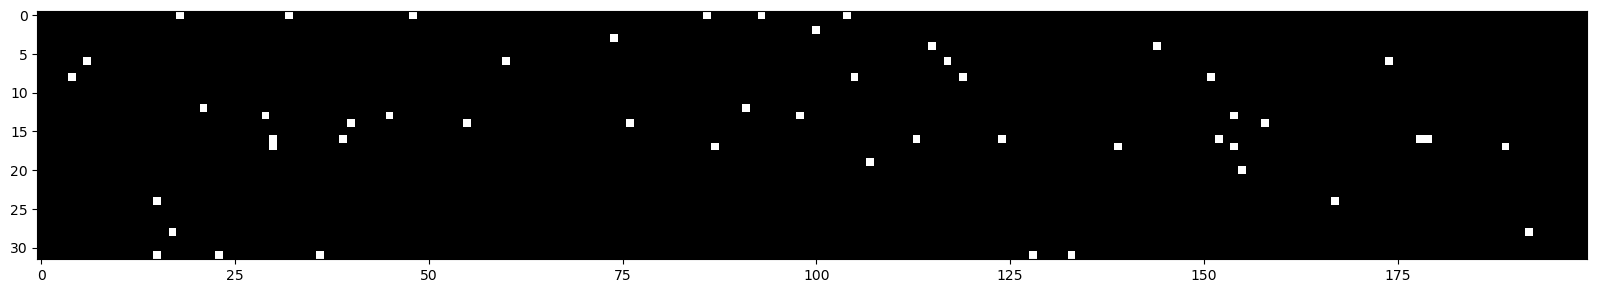

In [41]:
plt.figure(figsize = (20,10))
# Shows the 32 examples, and 200 hidden neurons
# White means exploding activations before going into the activation function
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')
# If we have a full column of white, this means that we have dead neurons
# No single example ever activates the tanh - if all examples land in the tails, then it will never learn

In [ ]:
# Sigmoid has the same issues since it is a squashing neuron
# For ReLU, gradients are zero'd out if they are negative - can get dead ReLU neuron
# Leaky ReLU does not suffer from it - since they do not have flat tails

# We want our pre-activations to be less bizzare. This way, we maximize the productive training time
# Initalization has an impact on performance
# Fix softmax being confidently wrong (first iteration)
# Fix tanh saturation at init
# Once we experiment with deep networks (50 layers), errors can stack up on eachother - less forgiving errors are

In [46]:
# Wasteful approach
# calibrate the batch norm at the end of training

with torch.no_grad(): # Disable gradient tracking
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
# bnmean, bnstd

In [45]:
# Compare the two values
# bnmean, bnmean_running

In [52]:
# Testing our model
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    
    hpreact = embcat @ W1 # + b1
    
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.1565091609954834
val 3.159217119216919


In [ ]:
### Summary - Batch Normalization
# Control the activations statistics in the neural net
# Placed after layers with multiplications - convolutional / linear layer
# Interally has bngain, and bnbias, trained by backprop
# Has two buffers - bnmean_running and bnstd_running, updated not trained
# Calculate activations feeding into layer - centering the activations to be unit gaussian
# Then offsetting and scalling  by the learned bias and gain
# Keep track of mean and stddev of the inputs, and maintaining the running values
# Running values are later used for inference
# Roughly Gaussian output - roughly gaussian input
# Prevent hockey stick losses to maximize productivity
# Control the activations using batch normalization - roughly Gaussian statistics
# Scale our weight and biases matrices down
# If we want roughly Gaussian outputs, normalize our outputs to mean 0, std dev 1. This operation is differentiable
# Estimate bnmean and bnstd as part of our training, in a running manner

In [ ]:
# ResNet50
# Made up of blocks - Bottleneck block
# Weight layer, normalization layer, non-linear layer

In [54]:
# PyTorchify our code

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps # epsilon
        self.momentum = momentum
        self.training = True
        # Parameters trained in backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True, unbiased = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) 
        self.out = self.gamma * xhat + self.beta
        # Update our buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
    
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
    
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [88]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  # batch X,Y
  Xb, Yb = Xtr[ix], Ytr[ix] 
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
    
  with torch.no_grad():
    # Ratio of values to gradients 
    ud.append([ ( (lr*p.grad).std() / p.data.std() ).log10().item() for p in parameters] )

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 1.8116


In [ ]:
# The gain affects our standard deviation - tanh layers squash our values and we need a gain to keep expanding to prevent squashing
# Non-linearities turn a linear transformation into a network that can approximate any arbitrary function

layer 2 (      Tanh): mean -0.01, std 0.68, saturated: 12.88%
layer 5 (      Tanh): mean +0.03, std 0.74, saturated: 17.00%
layer 8 (      Tanh): mean -0.01, std 0.76, saturated: 18.12%
layer 11 (      Tanh): mean -0.02, std 0.79, saturated: 19.38%
layer 14 (      Tanh): mean -0.00, std 0.79, saturated: 20.38%


Text(0.5, 1.0, 'activation distribution')

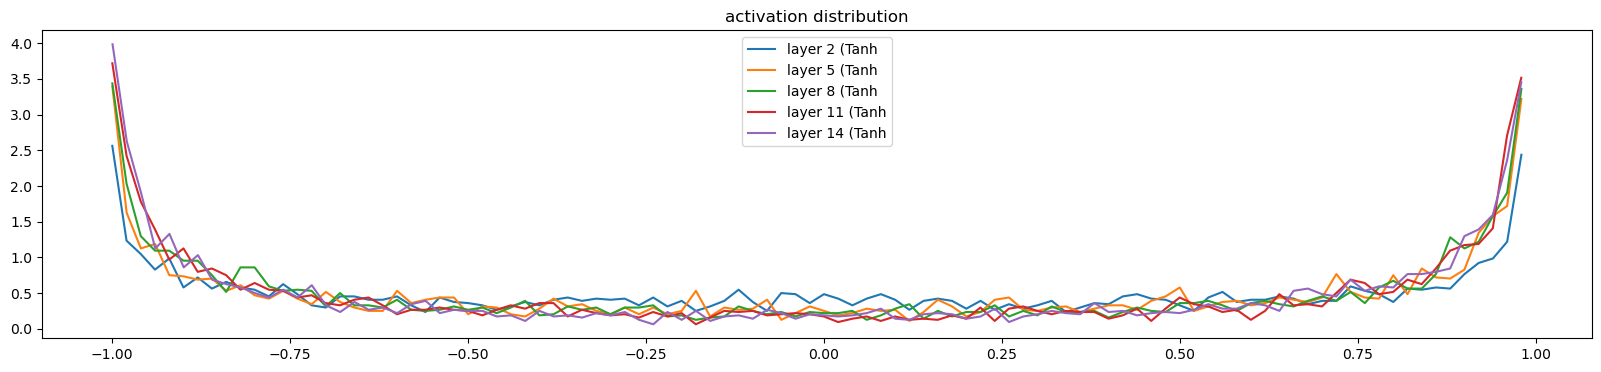

In [89]:
# visualize histograms - 1 - visualizing activations - forward pass
# Tells us if our neurons are too saturated or not
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000023, std 3.132849e-03
layer 5 (      Tanh): mean -0.000013, std 2.951951e-03
layer 8 (      Tanh): mean -0.000040, std 2.921312e-03
layer 11 (      Tanh): mean -0.000036, std 3.074088e-03
layer 14 (      Tanh): mean -0.000042, std 3.468231e-03


Text(0.5, 1.0, 'gradient distribution')

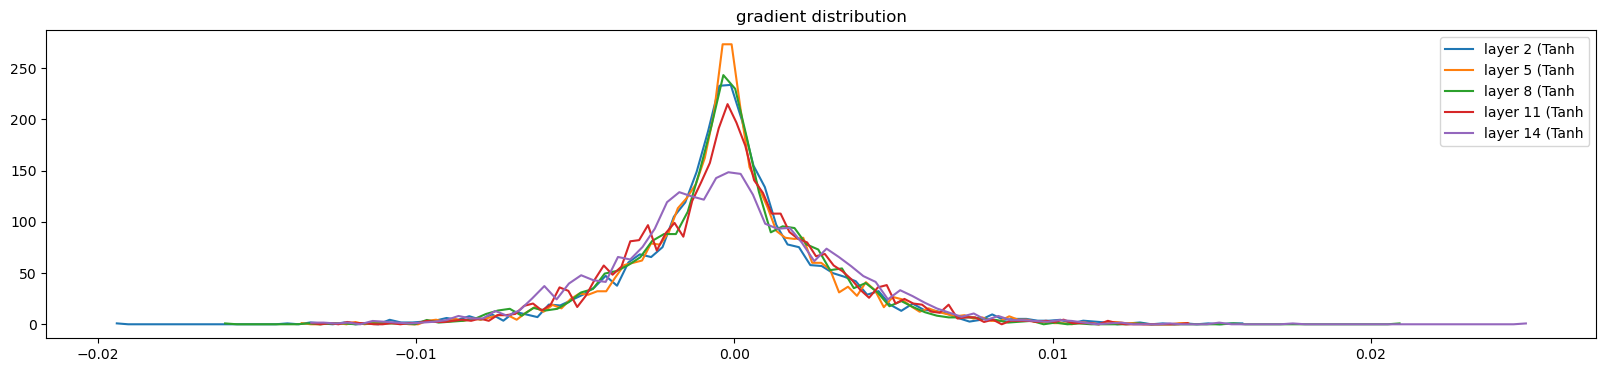

In [90]:
# visualize histograms - 2 - visualizing the gradients - backward pass
# Gradients are shrunk too much
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000776 | std 1.294467e-02 | grad:data ratio 1.201129e-02
weight  (30, 100) | mean -0.000098 | std 7.509400e-03 | grad:data ratio 1.924628e-02
weight (100, 100) | mean -0.000044 | std 4.817630e-03 | grad:data ratio 2.066072e-02
weight (100, 100) | mean -0.000031 | std 4.797912e-03 | grad:data ratio 2.090334e-02
weight (100, 100) | mean -0.000049 | std 4.766740e-03 | grad:data ratio 2.114744e-02
weight (100, 100) | mean +0.000042 | std 4.705644e-03 | grad:data ratio 2.156687e-02
weight  (100, 27) | mean -0.000007 | std 8.933767e-03 | grad:data ratio 2.924732e-02


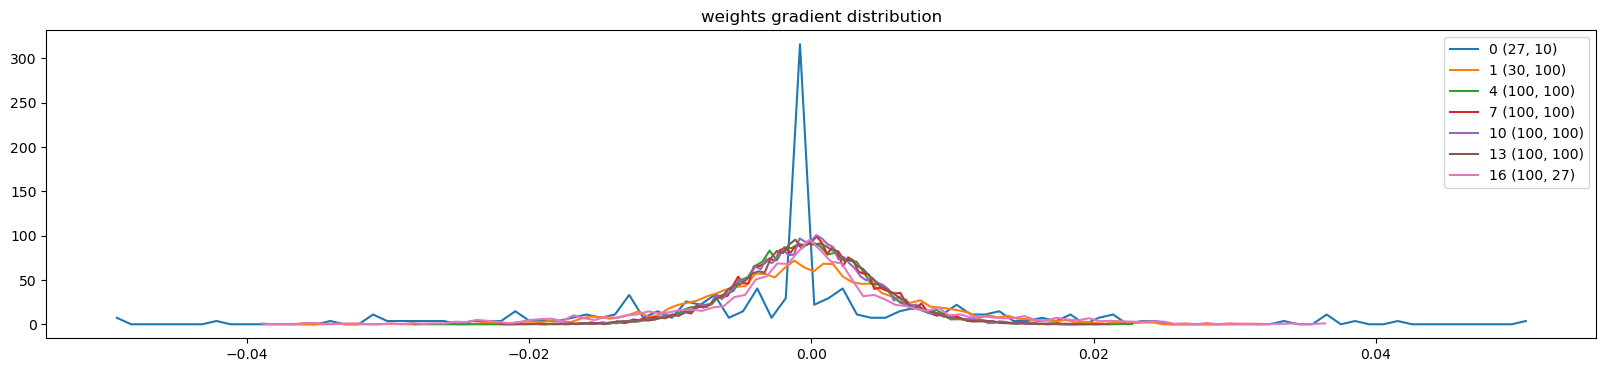

In [91]:
# visualize histograms - 3 - weights to be updated in gradient descent
# Gradient-data should be low numbers
# Gradient-data has assymetry and also bunches up
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

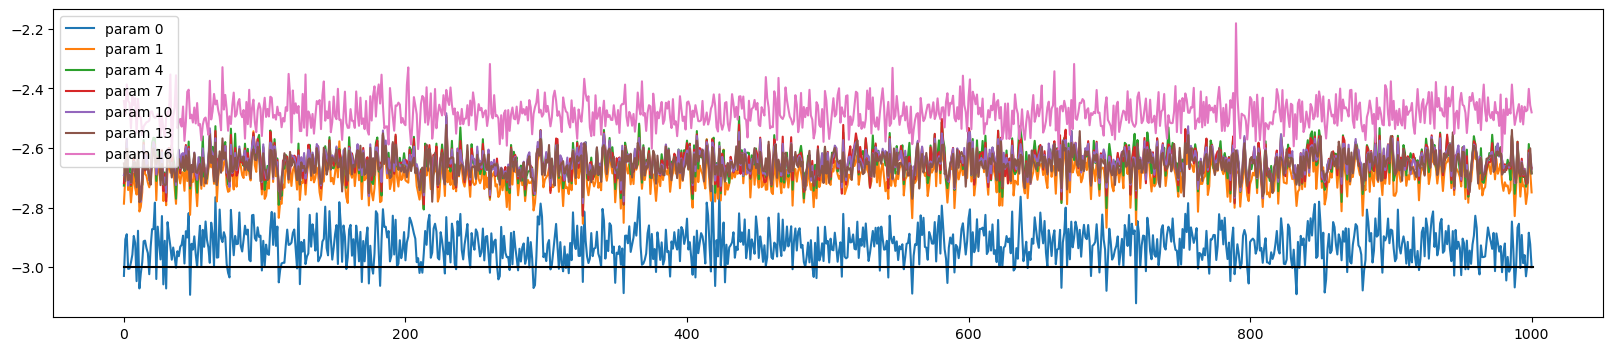

In [81]:
# Rough plot of what the ratios should be - actual updates to data over time
# Reveals if your learning rate is too small or not 
# Discrepancy in how fast neurons are changing
# Batchnorm prevents the need for fan_in proper initialization, and the only thing you need to worry about is the learning rate
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, (-3 from log scale is a rough heuristic) indicate on plot
plt.legend(legends);


In [92]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.061439275741577
val 2.136613607406616


In [93]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmahzari.
harlik.
mili.
tatyanna.
sane.
mahnee.
deliah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
prin.
quint.
shonora.
jadiquinte.
madiaryxi.
frankiirsley.
dae.
oip.


In [ ]:
# Bonus content

In [94]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [95]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [97]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
